In [2]:
# Встановлення пакету torchmetrics
!pip install torchmetrics
!pip install lightning

import torch
import torchmetrics
from torch import nn, optim
from torch.nn import functional as F
!pip install torchvision

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid", font_scale=1.5, font="SimHei", rc={"axes.unicode_minus":False})

import torch

import torchmetrics
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models

import lightning.pytorch as pl
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
pl.seed_everything(seed)

batch_size = 64

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = datasets.CIFAR10(root="./data", train=True, transform=train_transform, download=True)
val_dataset = datasets.CIFAR10(root="./data", train=False, transform=test_transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = val_loader


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   -- ------------------------------------- 0.1/1.2 MB 787.7 kB/s eta 0:00:02
   -------- ------------------------------- 0.3/1.2 MB 2.0 MB/s eta 0:00:01
   ------------------- -------------------- 0.6/1.2 MB 3.2 MB/s eta 0:00:01
   ---------------------------------------  1.2/1.2 MB 5.3 MB/s eta 0:00:01
   ---------------------------------------- 1.2/1.2 MB 4.7 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip
Seed set to 1


100%|██████████████████████████████████████████████████████████████| 170498071/170498071 [00:09<00:00, 17593824.60it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


['C:\\Windows\\Fonts\\bahnschrift.ttf', 'C:\\Windows\\Fonts\\simsun.ttc', 'C:\\Windows\\Fonts\\segoescb.ttf', 'C:\\Windows\\Fonts\\segoeprb.ttf', 'C:\\Windows\\Fonts\\Nirmala.ttf', 'C:\\Windows\\Fonts\\seguisbi.ttf', 'C:\\Windows\\Fonts\\ebrimabd.ttf', 'C:\\Windows\\Fonts\\mvboli.ttf', 'C:\\Windows\\Fonts\\seguibli.ttf', 'C:\\Windows\\Fonts\\verdana.ttf', 'C:\\Windows\\Fonts\\msyhbd.ttc', 'C:\\Windows\\Fonts\\l_10646.ttf', 'C:\\Windows\\Fonts\\YuGothL.ttc', 'C:\\Windows\\Fonts\\NirmalaB.ttf', 'C:\\Windows\\Fonts\\seguisli.ttf', 'C:\\Windows\\Fonts\\msjh.ttc', 'C:\\Windows\\Fonts\\segoeuisl.ttf', 'C:\\Windows\\Fonts\\segoeuii.ttf', 'C:\\Windows\\Fonts\\ntailu.ttf', 'C:\\Windows\\Fonts\\impact.ttf', 'C:\\Windows\\Fonts\\mmrtext.ttf', 'C:\\Windows\\Fonts\\seguisym.ttf', 'C:\\Windows\\Fonts\\consolab.ttf', 'C:\\Windows\\Fonts\\cambriab.ttf', 'C:\\Windows\\Fonts\\Candarab.ttf', 'C:\\Windows\\Fonts\\Sitka.ttc', 'C:\\Windows\\Fonts\\javatext.ttf', 'C:\\Windows\\Fonts\\comicz.ttf', 'C:\\Window

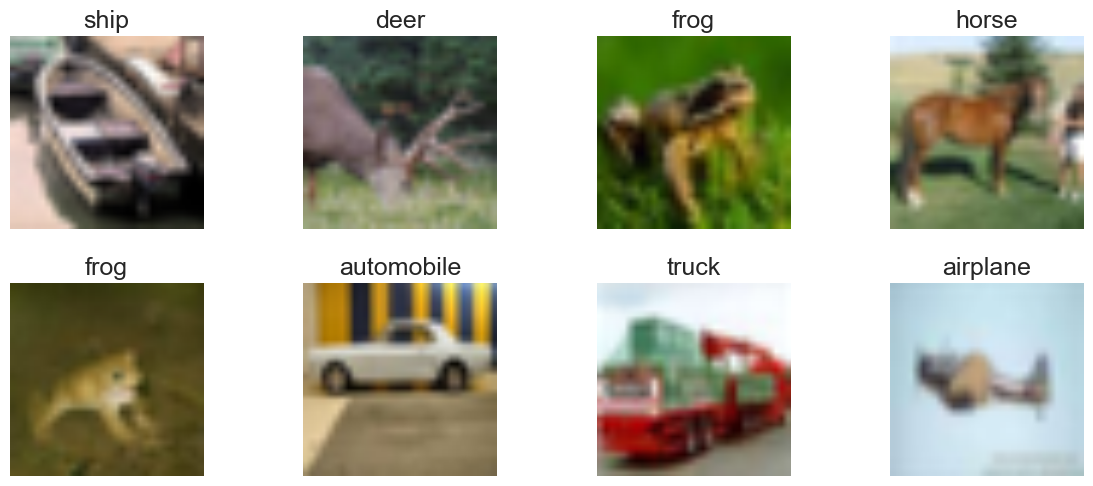

In [5]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Перевірка доступних шрифтів
print(fm.findSystemFonts(fontpaths=None, fontext='ttf'))

# Встановлення шрифту Arial для всіх графіків
plt.rcParams['font.family'] = 'Arial'

# код для створення графіків
plt.figure(figsize=(12, 20), dpi=100)
for images, labels in iter(val_loader):
    for i in range(8):
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(images[i].permute(1, 2, 0).numpy())
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.tight_layout()
plt.show()

In [6]:
class LitModel(pl.LightningModule):
    def __init__(self, num_classes=1000):
        super().__init__()
        self.model = models.resnet18(weights="IMAGENET1K_V1")
#         for param in self.model.parameters():
#             param.requires_grad = False
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
    
    def forward(self, x):
        x = self.model(x)
        return x
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.001, betas=(0.9, 0.99), eps=1e-08, weight_decay=1e-5)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.accuracy(y_hat, y)
        self.log('train_loss', loss, on_step=True, on_epoch=False, prog_bar=True, logger=True)
        self.log('train_acc', acc, on_step=True, on_epoch=False, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.accuracy(y_hat, y)
        self.log('val_loss', loss, on_step=False, on_epoch=True, logger=True)
        self.log('val_acc', acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        acc = self.accuracy(y_hat, y)
        self.log('test_acc', acc)
    
    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        x, y = batch
        y_hat = self(x)
        preds = torch.argmax(y_hat, dim=1)
        return preds

In [8]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint

# Ініціалізація необхідних об'єктів
num_classes = 10
model = LitModel(num_classes=num_classes)
logger = CSVLogger("./")
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=5, verbose=False, mode="min")
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="./checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    mode="min",
)

trainer = pl.Trainer(
    max_epochs=20, 
    enable_progress_bar=True, 
    logger=logger, 
    callbacks=[early_stop_callback, checkpoint_callback]
)

# Навчання моделі
trainer.fit(model, train_loader, val_loader)

# Збереження останнього стану моделі
trainer.save_checkpoint("final_model.ckpt")

# Збереження найкращого чекпоінту
best_model_path = checkpoint_callback.best_model_path
print(f"Best model saved at: {best_model_path}")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: ./lightning_logs

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | model    | ResNet             | 11.2 M | train
1 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|                                                              | 0/2 [00:00<?, ?it/s]

C:\Users\Igor\Vert_1\myenv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
C:\Users\Igor\Vert_1\myenv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


C:\Users\Igor\Vert_1\myenv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0: 100%|████████████████████████████████████████████| 782/782 [40:44<00:00,  0.32it/s, v_num=0, train_loss=0.608]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|█████████████████████████████| 782/782 [38:32<00:00,  0.34it/s, v_num=0, train_loss=0.246, val_acc=0.823]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|█████████████████████████████| 782/782 [39:57<00:00,  0.33it/s, v_num=0, train_loss=0.474, val_acc=0.859]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|█████████████████████████████| 782/782 [44:01<00:00,  0.30it/s, v_num=0, train_loss=0.172, val_acc=0.891]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████████████████████

In [23]:
# Перевірка кількості елементів у DataLoader
print(f'Number of batches in train_loader: {len(train_loader)}')
print(f'Number of batches in val_loader: {len(val_loader)}')

# Перевірка розміру batch'ів
train_batch = next(iter(train_loader))
val_batch = next(iter(val_loader))

print(f'Train batch size: {train_batch[0].size()}')
print(f'Validation batch size: {val_batch[0].size()}')

Number of batches in train_loader: 782
Number of batches in val_loader: 157
Train batch size: torch.Size([64, 3, 224, 224])
Validation batch size: torch.Size([64, 3, 224, 224])


In [30]:
import torch
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import pandas as pd
import numpy as np
from tqdm import tqdm

# Параметри
batch_size = 64
num_classes = 10

# Ініціалізація моделі
model = LitModel(num_classes=num_classes)

# Завантаження чекпоінту з параметрами, які мають невідповідність
checkpoint = torch.load('checkpoints/best-checkpoint.ckpt')
model.load_state_dict(checkpoint['state_dict'], strict=False)
model.eval()  # Перевести модель у режим оцінки

# Завантаження тестових даних
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

test_dataset = datasets.CIFAR10(root="./data", train=False, transform=test_transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Збір справжніх міток та прогнозів
all_labels = []
all_preds = []

# Використання tqdm для відображення прогресу
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating", unit="batch"):
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Обчислення classification_report
report = classification_report(all_labels, all_preds, target_names=test_dataset.classes, output_dict=True)

# Виведення результатів
print("Classification Report:")
print(pd.DataFrame(report).transpose())

Files already downloaded and verified


Evaluating: 100%|█████████████████████████████████████████████████████████████████| 157/157 [04:43<00:00,  1.81s/batch]

Classification Report:
              precision  recall  f1-score     support
airplane       0.911619  0.9180  0.914798   1000.0000
automobile     0.947835  0.9630  0.955357   1000.0000
bird           0.877571  0.8960  0.886690   1000.0000
cat            0.803355  0.8620  0.831645   1000.0000
deer           0.918593  0.9140  0.916291   1000.0000
dog            0.915621  0.8030  0.855621   1000.0000
frog           0.953252  0.9380  0.945565   1000.0000
horse          0.916746  0.9580  0.936919   1000.0000
ship           0.937126  0.9390  0.938062   1000.0000
truck          0.952041  0.9330  0.942424   1000.0000
accuracy       0.912400  0.9124  0.912400      0.9124
macro avg      0.913376  0.9124  0.912337  10000.0000
weighted avg   0.913376  0.9124  0.912337  10000.0000


In [31]:
import os

# Збереження моделі та результатів оцінки
output_dir = './output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

best_model_path = os.path.join(output_dir, "best_model.pth")
torch.save(model.state_dict(), best_model_path)

report_path = os.path.join(output_dir, "classification_report.csv")
pd.DataFrame(report).transpose().to_csv(report_path, index=True)

print(f"Best model saved at: {best_model_path}")
print(f"Classification report saved at: {report_path}")

# Завантаження та використання збереженої моделі
loaded_model = LitModel(num_classes=num_classes)
loaded_model.load_state_dict(torch.load(best_model_path))
loaded_model.eval()

# Використання завантаженої моделі для прогнозування
def predict(images):
    loaded_model.eval()
    with torch.no_grad():
        outputs = loaded_model(images)
        _, preds = torch.max(outputs, 1)
    return preds

# Приклад використання моделі для передбачення
sample_images, sample_labels = next(iter(test_loader))
predictions = predict(sample_images)

# Виведення результатів
print("Predictions:")
print(predictions)
print("True labels:")
print(sample_labels)

Best model saved at: ./output\best_model.pth
Classification report saved at: ./output\classification_report.csv
Predictions:
tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9,
        5, 5, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 9, 9, 5, 4, 6, 5, 6, 0, 9, 3, 8,
        7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 3, 3, 7, 3, 6, 3])
True labels:
tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9,
        5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6, 0, 9, 3, 9,
        7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 4, 6, 7, 3, 6, 3])


In [52]:
!pip install h5py
import h5py

def save_model_to_h5(model, filepath):
    # Збереження параметрів моделі
    model_state_dict = model.state_dict()

    with h5py.File(filepath, 'w') as h5_file:
        for key, value in model_state_dict.items():
            h5_file.create_dataset(key, data=value.cpu().numpy())

# Виклик функції для збереження моделі у форматі .h5
save_model_to_h5(model, 'C:/Users/Igor/Vert_1/output/model.h5')



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Files already downloaded and verified


Evaluating: 100%|█████████████████████████████████████████████████████████████████| 157/157 [03:42<00:00,  1.41s/batch]


Accuracy: 0.9124
Precision: 0.9134
Recall: 0.9124
F1 Score: 0.9123
Classification Report:
              precision  recall  f1-score     support
airplane       0.911619  0.9180  0.914798   1000.0000
automobile     0.947835  0.9630  0.955357   1000.0000
bird           0.877571  0.8960  0.886690   1000.0000
cat            0.803355  0.8620  0.831645   1000.0000
deer           0.918593  0.9140  0.916291   1000.0000
dog            0.915621  0.8030  0.855621   1000.0000
frog           0.953252  0.9380  0.945565   1000.0000
horse          0.916746  0.9580  0.936919   1000.0000
ship           0.937126  0.9390  0.938062   1000.0000
truck          0.952041  0.9330  0.942424   1000.0000
accuracy       0.912400  0.9124  0.912400      0.9124
macro avg      0.913376  0.9124  0.912337  10000.0000
weighted avg   0.913376  0.9124  0.912337  10000.0000


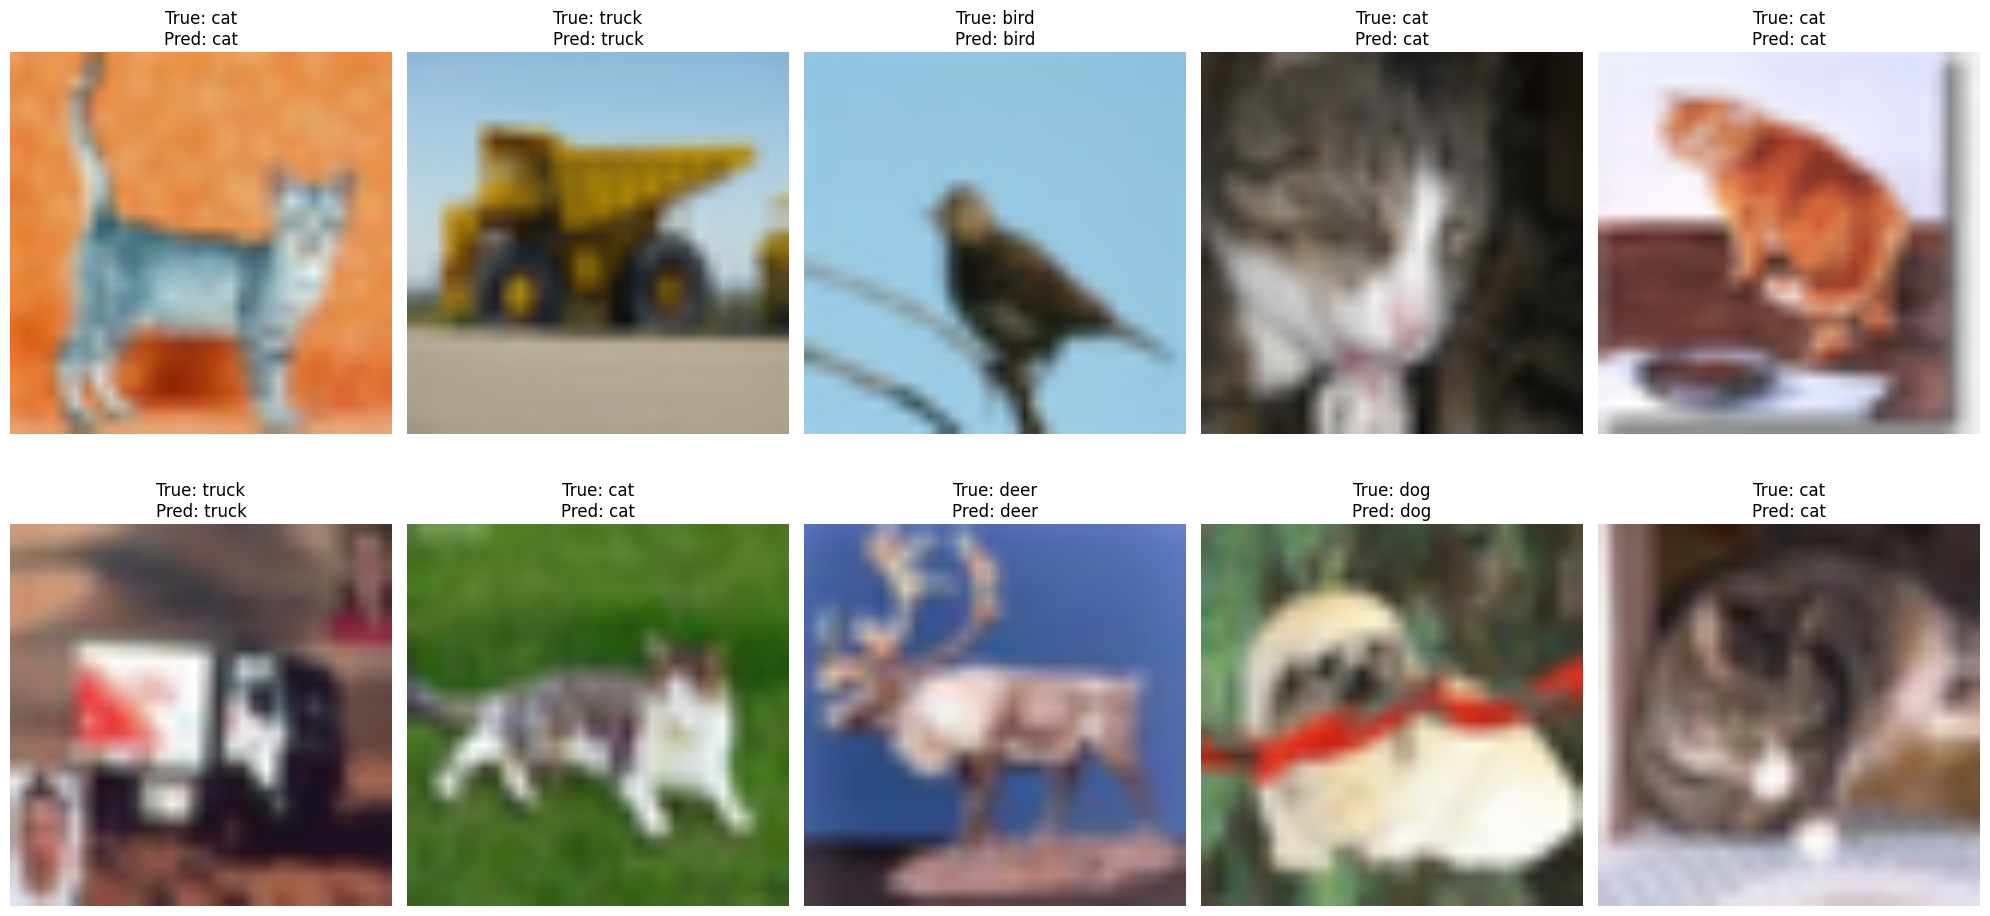

In [4]:
import torch
import torchmetrics
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import h5py
from collections import OrderedDict
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import lightning.pytorch as pl

class LitModel(pl.LightningModule):
    def __init__(self, num_classes=1000):
        super().__init__()
        self.model = models.resnet18(weights="IMAGENET1K_V1")
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        x = self.model(x)
        return x

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.001, betas=(0.9, 0.99), eps=1e-08, weight_decay=1e-5)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.accuracy(y_hat, y)
        self.log('train_loss', loss, on_step=True, on_epoch=False, prog_bar=True, logger=True)
        self.log('train_acc', acc, on_step=True, on_epoch=False, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.accuracy(y_hat, y)
        self.log('val_loss', loss, on_step=False, on_epoch=True, logger=True)
        self.log('val_acc', acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        acc = self.accuracy(y_hat, y)
        self.log('test_acc', acc)

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        x, y = batch
        y_hat = self(x)
        preds = torch.argmax(y_hat, dim=1)
        return preds

# Функція для завантаження моделі з .h5 файлу
def load_model_from_h5(model, filepath):
    with h5py.File(filepath, 'r') as h5_file:
        state_dict = OrderedDict()
        for key in h5_file.keys():
            state_dict[key] = torch.tensor(h5_file[key][()])
    model.load_state_dict(state_dict)
    return model

# Ініціалізація моделі
num_classes = 10
model = LitModel(num_classes=num_classes)

# Завантаження моделі з .h5 файлу
model = load_model_from_h5(model, 'C:/Users/Igor/Vert_1/output/model.h5')
model.eval()  # Перевести модель у режим оцінки

# Завантаження тестових даних
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

test_dataset = datasets.CIFAR10(root="./data", train=False, transform=test_transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Збір справжніх міток та прогнозів
all_labels = []
all_preds = []
all_images = []

# Використання tqdm для відображення прогресу
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating", unit="batch"):
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_images.extend(images.cpu().numpy())

# Обчислення метрик
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

# Виведення метрик
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Обчислення classification_report
report = classification_report(all_labels, all_preds, target_names=test_dataset.classes, output_dict=True)

# Виведення результатів
print("Classification Report:")
print(pd.DataFrame(report).transpose())

# Виведення 10 випадкових зображень з їх мітками
random_indices = random.sample(range(len(all_images)), 10)

plt.figure(figsize=(20, 10))
for i, idx in enumerate(random_indices):
    img = np.transpose(all_images[idx], (1, 2, 0))  # Зміна порядку осей для візуалізації
    true_label = test_dataset.classes[all_labels[idx]]
    pred_label = test_dataset.classes[all_preds[idx]]
    
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()